# Lesson 11 神经网络的学习

- 回顾梯度下降
  1. 梯度下降的基本流程是什么，它是怎么找到损失函数的最小值的（写出流程）？  
     对目标函数关于参数求偏导
  2. 梯度下降中是如何迭代权重 的（写出公式）？
       - $$w_{i+1} = w_i - \alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

  3. 什么是梯度？什么是步长？
       - 梯度：目标函数变化最快速度的反方向
       - 步长：原点移动的长度
      
## 一、梯度下降中的两个关键问题

### 1.找出梯度的方向和大小
- 梯度向量是多元函数上，各个自变量的偏导数组成的向量，这些偏导数的具体值必须依赖于当前所在坐标点的值进行计算。

### 2.进行迭代
$$w_{(t+1)}=w_{(t)}-\eta\frac{\partial}{\partial w}L(w)$$
是我们迭代权重的迭代公式，其中偏导数的大小影响整体梯度向量的大小，偏导数前的剪号影响整体梯度向量的方向

In [3]:
#————————————————————————————绘图————————————————————————————

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import numpy as np

w1 = np.arange(-10,10,0.05)
w2 = np.arange(-10,10,0.05)
w1, w2 = np.meshgrid(w1, w2)
lossfn = (2 - w1 - w2)**2 + (4 - 3*w1 - w2)**2
#定义一个绘制三维图像的函数
#elev表示上下旋转的角度
#azim表示平行旋转的角度

def plot_3D(elev=45,azim=60,X=w1,y=w2):
    fig, ax = plt.subplots(1, 1,constrained_layout=True, figsize=(8, 8))
    ax = plt.subplot(projection="3d")
    ax.plot_surface(w1, w2, lossfn, cmap='rainbow',alpha=0.7)
    ax.view_init(elev=elev,azim=azim)
    #ax.xticks([-10,-5,0,5,10])
    #ax.set_xlabel("w1",fontsize=20)
    #ax.set_ylabel("w2",fontsize=20)
    #ax.set_zlabel("lossfn",fontsize=20)
    plt.show()

from ipywidgets import interact,fixed
interact(plot_3D,elev=[0,15,30],azip=(-180,180),X=fixed(w1),y=fixed(w2))
plt.show()


interactive(children=(Dropdown(description='elev', options=(0, 15, 30), value=0), IntSlider(value=60, descript…

## 二、找出距离和方向：反向传播

### 1.反向传播的定义与价值

我们是从左向右，**从输出向输入**，逐渐往前求解导数的表达式，并且我们所使用的节点上的张量，也是从后向前逐渐用到，这和正向传播的过程完全相反。这种从左到右，不断使用正向传播中的元素对梯度向量进行计算的方式，就是反向传播

### 2.PyTorch实现反向传播


In [5]:
import torch
x = torch.tensor(1.,requires_grad = True)
z = x ** 2

torch.autograd.grad(z,x)

#=这里返回的是在函数y=x**2上，x=1时的导数值。

(tensor(2.),)

- 对于单层神经网络，autograd.grad会非常有效。但深层神经网络就不太适合使用grad函数了。
- PyTorch提供的基于autograd的反向传播功能，`lossfunction.backward()`来进行计算。
  - `criterion = lossfunction.backward()`
  - `loss = criterion(预测值,真实值.long())`
    - 其中真实值必须是整形

In [8]:
#导入库、数据、定义神经网络类，完成正向传播
#继承nn.Module类完成正向传播
import torch
import torch.nn as nn
from torch.nn import functional as F


In [26]:
# 3分类 500个样本，20个特征，共三层，第一层13个，第二层8个神经元

# 生成数据
torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32)
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)


In [27]:
#————————————————————————————建立神经网络的架构————————————————————————————
# logsoftmax + NLLLoss / CrossEntoryLoss

class Model(nn.Module):
    def __init__(self,in_features=20,out_features=3) -> None:
        super(Model,self).__init__()
        self.linear1 = nn.Linear(in_features,13,bias=True)
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)

    # 定义向前传播的激活函数
    def forward(self,x):
        sigma1 = torch.relu(self.linear1(X))  # 一行完成
        z2 = self.linear2(sigma1)
        sigma2 = torch.sigmoid(z2)
        zhat = self.output(sigma2)
        # sigma3 = F.softmax(z3,dim=1)  # 不使用sigmoid
        return zhat

In [28]:
#————————————————————————————实例化神经网络类————————————————————————————
input_ = X.shape[1] #特征的数目
output_ = len(y.unique()) #分类的数目

torch.manual_seed(420)
net = Model(in_features=input_,out_features=output_)

In [29]:
#————————————————————————————前向传播————————————————————————————
zhat = net.forward(X)
zhat


tensor([[-0.0272, -0.1963, -0.5871],
        [ 0.0023, -0.1955, -0.5866],
        [-0.0770, -0.1754, -0.6096],
        ...,
        [-0.0045, -0.1997, -0.5832],
        [-0.0225, -0.2066, -0.5743],
        [-0.0200, -0.2079, -0.5665]], grad_fn=<AddmmBackward0>)

In [30]:
#————————————————————————————定义损失函数————————————————————————————
criterion = nn.CrossEntropyLoss()  # 实例化
loss = criterion(zhat,y.long())
loss

tensor(1.1184, grad_fn=<NllLossBackward0>)

In [31]:
net.linear1.weight.grad  
# 还没有反向传播 所以不会返回任何值

In [32]:
#————————————————————————————反向传播————————————————————————————
loss.backward()

net.linear1.weight.grad  # 返回相应的梯度

tensor([[ 1.3761e-05,  1.0973e-05,  6.8629e-06, -1.5644e-06,  1.9487e-05,
         -5.9836e-06,  2.4508e-05,  1.1144e-05,  5.4205e-06, -7.4555e-06,
          4.8241e-06,  1.8250e-05, -3.3542e-06,  1.3879e-05,  1.0864e-05,
         -1.6416e-05,  1.5331e-05,  1.6790e-06,  2.5084e-05,  1.1616e-05],
        [ 1.0856e-03,  1.7819e-03,  1.8401e-03,  1.2384e-03,  1.1341e-03,
          1.0446e-03,  1.1615e-03,  1.1535e-03,  1.5216e-03,  1.1517e-03,
          1.3311e-03,  1.3067e-03,  1.5875e-03,  1.2309e-03,  1.2933e-03,
          1.3691e-03,  1.3698e-03,  1.2086e-03,  9.7722e-04,  1.0946e-03],
        [-4.9581e-05, -1.1706e-04, -2.7976e-04, -9.5992e-05, -3.9125e-04,
         -5.3201e-04, -2.9250e-04,  3.6262e-05, -6.4736e-04, -2.6931e-04,
         -4.7741e-04, -2.4125e-04, -4.9524e-04, -1.6649e-04, -5.6666e-04,
         -2.1780e-06, -2.2611e-04, -4.0575e-04, -1.9789e-04, -8.4060e-05],
        [ 2.8862e-04,  3.1539e-04,  2.6116e-04,  2.2272e-04,  1.4244e-04,
          2.4812e-04,  1.7803e-04, 

In [35]:
#与可以重复进行的正向传播不同，一次正向传播后，反向传播只能进行一次
#如果希望能够重复进行反向传播，可以在进行第一次反向传播的时候加上参数retain_graph

loss.backward(retain_graph=True)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

- 我们在定义损失函数时，并没有告诉损失函数哪些值是自变量，哪些是常数，那backward函数是怎么判断具体求解哪个对象的梯度的呢？

    - 其实就是靠requires_grad。首先backward值会识别叶子节点，不在叶子上的变量是不会被backward考虑的。

如果你的$w$是自己设置的，一定要设置requires_grad=True。


## 三、移动坐标点

### 1.走出第一步

- 权重的迭代公式
 $$w_{(t+1)} = w_{t} - \eta \frac{\partial L(w)}{\partial w}$$


In [36]:
# 学习率一般都设置的很小

#在这里，我们的数据是生成的随机数，为了让大家看出效果，所以我才设置了步长为10，正常不会使用这么大的步长
#步长、学习率的英文是learning rate，所以常常简写为lr
lr = 10

dw = net.linear1.weight.grad
w = net.linear1.weight.data

In [39]:
#对任意w可以有
w -= lr * dw
w

tensor([[ 0.1361, -0.1349,  0.2126, -0.1776, -0.0688, -0.1539,  0.1717,  0.0836,
         -0.1117, -0.1727, -0.1296, -0.0437, -0.1140,  0.1625, -0.0944, -0.1458,
         -0.0694, -0.2184, -0.1093, -0.1223],
        [ 0.0156,  0.1284, -0.0311, -0.1675,  0.0580, -0.1265, -0.1407, -0.0775,
         -0.1623, -0.0100,  0.1416, -0.0087,  0.0874, -0.2312, -0.2147, -0.0708,
         -0.0409,  0.1033, -0.2260,  0.0605],
        [-0.1904,  0.0396,  0.1562,  0.0337,  0.0831,  0.1581,  0.2300, -0.1414,
          0.0927,  0.1922,  0.1415, -0.1953, -0.1402, -0.2140,  0.1160,  0.2213,
         -0.2098,  0.1910, -0.2033, -0.0248],
        [ 0.1728, -0.0446,  0.0170,  0.1563, -0.1918,  0.0491, -0.1145,  0.2009,
         -0.2001,  0.0122,  0.1330, -0.1349, -0.1390,  0.0709, -0.1817,  0.1268,
          0.0237, -0.2218,  0.0735, -0.1849],
        [ 0.0311,  0.1454, -0.0359,  0.0963,  0.0004, -0.1640, -0.2077,  0.2006,
          0.0634,  0.0834, -0.2064, -0.0212,  0.0316, -0.1893, -0.1924,  0.1244,
      

### 2.动量法Momentum

我们让**上一步的梯度向量与现在这一点的梯度向量以加权的方式求和**，求解出受到上一步大小和方向影响的真实下降方向，再让坐标点向真实下降方向移动。  
其中，对上一步的梯度向量加上的权重被称为动量参数$\gamma$，对这一点的梯度向量加上的权重就是步长$\eta$，真实移动的向量为$v$，被称为动量（Momentum）。将上述过程使用公式表示，则有：

$$v_{(t)}=\gamma v_{(t-1)} - \eta\frac{L}{\partial w}$$
$$w_{(t+1)}=w_{(t)}+v_{(t)}$$

在第一步中，没有历史梯度方向，因此第一步的真实方向就是起始点梯度的反方向，$v_0=0$ 。其中$v_{(t-1)}$代表了之前所有步骤所累积的动量和。

- 一直往一个方向走，就迈大步走；换一个方向就迈小步

In [40]:
# momentum

# v(t) = gamma *v(t-1) - lr *dw
# w(t+1) = w(t) + v(t)

lr = 0.1
gamma = 0.9

dw = net.linear1.weight.grad
w = net.linear1.weight.data


In [42]:
# t =1 , 走第一步，进行首次迭代的时候需要一个v0

dw.shape

v = torch.zeros(dw.shape[0],dw.shape[1])
#v要能够跟dw相减，因此必须和dw保持相同的结构，初始v为0，但后续v会越来越大


In [43]:
#==========分割cell，不然重复运行的时候w会每次都被覆盖掉=============
#对任意w可以有
v = gamma * v - lr * dw
w -= v
w
#不难发现，当加入gamma之后，即便是较小的步长，也可以让w发生变化


tensor([[ 0.1361, -0.1349,  0.2126, -0.1776, -0.0688, -0.1539,  0.1717,  0.0836,
         -0.1117, -0.1727, -0.1296, -0.0437, -0.1140,  0.1625, -0.0944, -0.1458,
         -0.0694, -0.2184, -0.1093, -0.1223],
        [ 0.0157,  0.1286, -0.0309, -0.1673,  0.0581, -0.1264, -0.1406, -0.0773,
         -0.1622, -0.0099,  0.1417, -0.0086,  0.0876, -0.2311, -0.2146, -0.0707,
         -0.0408,  0.1034, -0.2259,  0.0606],
        [-0.1904,  0.0396,  0.1561,  0.0337,  0.0831,  0.1581,  0.2300, -0.1414,
          0.0926,  0.1921,  0.1414, -0.1953, -0.1403, -0.2140,  0.1159,  0.2213,
         -0.2098,  0.1909, -0.2033, -0.0248],
        [ 0.1728, -0.0446,  0.0170,  0.1563, -0.1918,  0.0492, -0.1144,  0.2009,
         -0.2001,  0.0123,  0.1330, -0.1349, -0.1390,  0.0709, -0.1817,  0.1268,
          0.0237, -0.2218,  0.0735, -0.1849],
        [ 0.0311,  0.1454, -0.0359,  0.0962,  0.0003, -0.1640, -0.2077,  0.2005,
          0.0635,  0.0833, -0.2064, -0.0212,  0.0317, -0.1893, -0.1923,  0.1244,
      

### 3.torch.optim实现带动量的梯度下降

**建立神经网络的步骤**
- 导入库
- 确定数据、超参数的确定
- 定义神经网络的架构类Model,定义类Model需要输入的参数
- 实例化神经网络的类 --> 让神经网络准备好进行正向传播
- 定义损失函数
- 定义优化算法
  - `optim.SGD(net.parameters(), lr=学习率, momentum =动量参数)`
- 前项传播
- 本轮向前传播的损失函数值
- 反向传播-得到了梯度
- 更新权重（和动量）
- 清空梯度 - 清楚原来计算的，基于上一个点的坐标计算的梯度

In [46]:
#————————————————————————————前面代码的整合————————————————————————————
#导入库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

#确定数据、确定优先需要设置的值
lr = 0.1
gamma = 0.9
torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32) * 100
y = torch.randint(low=0,high=3,size=(500,1),dtype=torch.float32)
input_ = X.shape[1] #特征的数目
output_ = len(y.unique()) #分类的数目

#定义神经网路的架构
class Model(nn.Module):
    def __init__(self,in_features=10,out_features=2):
        super(Model,self).__init__() #super(请查找这个类的父类，请使用找到的父类替换现在的类)
        self.linear1 = nn.Linear(in_features,13,bias=True) #输入层不用写，这里是隐藏层的第一层
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)
        
    def forward(self, x):
        z1 = self.linear1(x)
        sigma1 = torch.relu(z1)
        z2 = self.linear2(sigma1)
        sigma2 = torch.sigmoid(z2)
        z3 = self.output(sigma2)
        #sigma3 = F.softmax(z3,dim=1)
        return z3

#实例化神经网络，调用优化算法需要的参数
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)
net.parameters()
  

<generator object Module.parameters at 0x000001F3F48641C8>

In [44]:
  
#定义损失函数
criterion = nn.CrossEntropyLoss()


In [47]:
# 一次性导入现有神经网络架构的所有参数
for x in net.parameters():
    print(x)

Parameter containing:
tensor([[ 1.3656e-01, -1.3459e-01,  2.1281e-01, -1.7763e-01, -6.8218e-02,
         -1.5410e-01,  1.7245e-01,  8.3885e-02, -1.1153e-01, -1.7294e-01,
         -1.2947e-01, -4.3138e-02, -1.1413e-01,  1.6295e-01, -9.4082e-02,
         -1.4629e-01, -6.8982e-02, -2.1836e-01, -1.0859e-01, -1.2199e-01],
        [ 4.8127e-02,  1.8186e-01,  2.4149e-02, -1.3032e-01,  9.2056e-02,
         -9.5202e-02, -1.0584e-01, -4.2852e-02, -1.1669e-01,  2.4581e-02,
          1.8152e-01,  3.0500e-02,  1.3506e-01, -1.9425e-01, -1.7591e-01,
         -2.9751e-02,  2.0485e-04,  1.3957e-01, -1.9666e-01,  9.3293e-02],
        [-1.9192e-01,  3.6070e-02,  1.4778e-01,  3.0845e-02,  7.1393e-02,
          1.4217e-01,  2.2122e-01, -1.4032e-01,  7.3255e-02,  1.8409e-01,
          1.2716e-01, -2.0253e-01, -1.5509e-01, -2.1899e-01,  9.8980e-02,
          2.2123e-01, -2.1659e-01,  1.7880e-01, -2.0922e-01, -2.7275e-02],
        [ 1.8144e-01, -3.5166e-02,  2.4801e-02,  1.6299e-01, -1.8755e-01,
          5.6

In [48]:
#定义优化算法
opt = optim.SGD(net.parameters() #要优化的参数是哪些？
               , lr=lr #学习率
               , momentum = gamma #动量参数
               )

# 第一参数是参数,学习率,动量参数

接下来开始进行一轮梯度下降：


In [71]:
#————————————————————————————重要❤：迭代方法————————————————————————————
# 前向传播
zhat = net.forward(X)

# 计算损失函数
loss = criterion(zhat,y.reshape(500).long())
loss.backward()

# 走一步
opt.step()  # 更新权重w，从这一瞬间开始，坐标点就发生了变化，所有的梯度必须重新计算
opt.zero_grad() #清除原来储存好的，基于上一个坐标点计算的梯度，为下一次计算梯度腾出空间

print(loss)
print(net.linear1.weight.data[0][:10])


# 每运行一次 loss都会减少

tensor(1.0529, grad_fn=<NllLossBackward0>)
tensor([ 0.1350, -0.1350,  0.2109, -0.1778, -0.0689, -0.1544,  0.1707,  0.0825,
        -0.1120, -0.1732])


## 四、开始迭代：batch_size与epoches

### 1.小批量梯度下降

小批量随机梯度下降（简写为mini-batch SGD）。小批量随机梯度下降的求解与迭代流程与传统梯度下降（GD）基本一致，不过二者在迭代权重时使用的数据这一点上存在巨大的不同。
- 传统梯度下降在每次进行权重迭代（即循环）时都使用全部数据，每次迭代所使用的数据也都一致。
- 随机梯度下降，每个批次里只有一个样本,梯度下降的迭代轨迹就会变得异常不稳定,计算过慢
- 而mini-batch SGD是每次迭代前都会从整体采样一批固定数目的样本组成批次（batch）$B$，并用$B$中的样本进行梯度计算，以减少样本量。
  - mini-batch SGD更可能找到全局最小值
  - mini-batch SGD可以提升神经网络的计算效率，让神经网络计算更快

### 2.batch_size与epoches

- 选择的批量batch含有的样本数被称为`batch_size`，这个尺寸一定是小于数据量的某个正整数值
- `epoch`是衡量训练数据被使用次数的单位，
  - 一个epoch表示优化算法将全部训练数据都使用了一次，我们常使用“完成1个epoch需要n次迭代“这样的语言

```
for epochs in range(epoch):
    for batch in range(batch):
        zhat = net.forward(X)  # 最后一个线性层的输出结果，前向传播
        loss = criterion(zhat,y.reshape(500).long())  # 计算损失函数
        
        loss.backward()
        opt.step() # 走一步
        opt.zero_grad()
```


### 3.TensorDataset与DataLoader

torch中用于预处理的两个类
- `DataLoader` 用与切割小批量的类
  - `dataset = DataLoader(data,batch_size=抽样的大小,shuffle=是否打乱抽样,drop_last=是否舍弃最后一个batch)`
    - bs 输入正数即可 
  - 属性`batch_size`查看现在的batch_size是多少
  - `len(dataset)`返回多少个batch
  - `len(dataset.dataset)` 返回有多少个样本
- TensorDataset 合并数据：要求数据的第一维度上的值相等

In [75]:
import torch
from torch.utils.data import TensorDataset

a = torch.randn(500,2,3)  # 三维数据
b = torch.randn(500,3,4,5)  # 四维数据
c = torch.randn(500,1)  # 二维数据



In [77]:
# 被合并的数据第一维度上的值相等
TensorDataset(a,b,c)
for x in TensorDataset(a,b,c):
    print(x)
    break


(tensor([[ 0.1243,  0.4218, -0.0191],
        [-1.1607, -0.4629,  0.7467]]), tensor([[[ 0.1839,  0.9627,  1.4169, -0.5208, -0.0273],
         [-0.0235, -0.4743,  0.7232,  0.1129, -0.9538],
         [ 0.6910, -1.3103,  0.2457,  0.4946,  0.1170],
         [-0.3008, -0.7154,  0.8117,  0.7465, -0.4695]],

        [[ 0.0158, -0.0928,  0.0184, -0.3890, -0.3316],
         [ 0.8901,  0.6421, -0.8500, -0.3790, -0.8492],
         [-0.4432, -0.6814,  0.5305, -1.1311,  0.9367],
         [-0.4199, -1.5849,  1.8307, -0.5568,  1.1463]],

        [[ 0.4434, -0.5125, -1.1083,  0.9996,  0.5958],
         [-0.6915, -0.9653,  0.0378,  1.3866, -0.9301],
         [ 1.8503, -0.3203, -0.6716, -0.3436, -0.2124],
         [ 0.5932,  0.4367, -1.8365,  0.6224, -1.4629]]]), tensor([0.4655]))


In [79]:
data =  TensorDataset(b,c)


In [80]:
from torch.utils.data import DataLoader

for x in DataLoader(data):
    print(X)
    break

tensor([[80.5354, 19.9040, 97.5853,  ...,  1.1728, 25.7179, 22.7224],
        [60.7616, 90.6643, 55.3998,  ..., 81.2087,  6.0260, 70.8609],
        [ 7.0843, 58.0655, 83.0440,  ..., 89.9817,  3.2177, 43.9011],
        ...,
        [79.8613, 67.0805, 72.9771,  ..., 12.6831, 13.0960, 85.5574],
        [66.3387, 89.4342, 95.2700,  ..., 20.2950, 39.9825, 23.0228],
        [70.8147, 10.6863, 12.6333,  ...,  1.5278, 47.2199,  7.1780]])


In [81]:
bs = 120

In [83]:
dataset =  DataLoader(data,
           batch_size= bs,  # 抽样的大小
           shuffle=True,   # 是否打乱抽样
            drop_last=True  # 是否舍弃最后一个batch（无法除今的部分） 一般都是False
            )


#查看一下生成的对象
for i in dataset:
    print(i)

[tensor([[[[ 5.0350e-01, -2.5785e-01, -7.4411e-01,  4.8481e-01, -3.3028e-01],
          [ 1.7720e+00,  4.3487e-01,  2.4103e+00,  1.0993e+00,  1.6905e-01],
          [-1.5238e+00, -2.7925e-01,  3.0360e-01, -1.5479e+00, -1.4451e+00],
          [ 1.7829e-01,  7.3875e-01, -5.7917e-01,  3.4826e-01,  1.8869e+00]],

         [[-1.4717e+00,  9.7736e-01,  1.5970e-01, -5.6110e-01,  1.6295e+00],
          [-1.0495e+00, -6.5790e-01,  1.0529e+00,  1.3748e-01,  7.9938e-02],
          [-4.2732e-01,  9.6678e-01,  5.8481e-02,  1.1538e+00, -2.2755e+00],
          [ 5.1710e-01, -1.6784e+00,  2.7139e-01,  8.8691e-02,  1.3170e+00]],

         [[ 3.2207e-01,  9.4099e-01, -1.0966e+00,  7.2319e-01,  1.6767e-01],
          [ 1.2207e+00, -1.8586e-01,  4.8526e-01,  1.1862e+00,  2.0376e-03],
          [ 7.3086e-02,  1.0813e+00, -1.1925e+00,  3.0230e+00, -9.3491e-01],
          [ 1.4111e+00, -1.0762e+00,  2.5075e+00,  7.5943e-01,  1.5455e+00]]],


        [[[-1.3630e+00, -1.6867e+00, -2.0737e-03,  3.3542e+00, -2.7

In [85]:
# 返回一共有多少个batch
len(dataset)

4

In [87]:
# 返回一共有多少个样本
len(dataset.dataset)

500

In [89]:
dataset.dataset[0][0]#一个样本的特征张量


tensor([[[ 0.1839,  0.9627,  1.4169, -0.5208, -0.0273],
         [-0.0235, -0.4743,  0.7232,  0.1129, -0.9538],
         [ 0.6910, -1.3103,  0.2457,  0.4946,  0.1170],
         [-0.3008, -0.7154,  0.8117,  0.7465, -0.4695]],

        [[ 0.0158, -0.0928,  0.0184, -0.3890, -0.3316],
         [ 0.8901,  0.6421, -0.8500, -0.3790, -0.8492],
         [-0.4432, -0.6814,  0.5305, -1.1311,  0.9367],
         [-0.4199, -1.5849,  1.8307, -0.5568,  1.1463]],

        [[ 0.4434, -0.5125, -1.1083,  0.9996,  0.5958],
         [-0.6915, -0.9653,  0.0378,  1.3866, -0.9301],
         [ 1.8503, -0.3203, -0.6716, -0.3436, -0.2124],
         [ 0.5932,  0.4367, -1.8365,  0.6224, -1.4629]]])

In [90]:
dataset.dataset[0][1]#一个样本的标签


tensor([0.4655])

In [92]:
#属性batch_size，查看现在的batch_size是多少
dataset.batch_size

120

In [96]:
#我们在迭代的时候，常常这样使用：
for batch_idx, (x,y) in enumerate(dataset):
    #sigma = net(x)
    #loss = lossfn(sigma, y)
    #loss.backward()
    #opt.step()
    #opt.zero_grad()
    print(x.shape)
    print(y.shape)
    print(x,y)
    if batch_idx == 2:
        break 
#为了演示用，所以打断，在正常的循环里是不会打断的



torch.Size([120, 3, 4, 5])
torch.Size([120, 1])
tensor([[[[-1.1162,  0.4814, -0.4366, -1.0283, -0.7599],
          [ 0.9442, -0.5389,  0.8575, -0.0847, -0.0576],
          [ 0.6647,  0.3784,  1.4073,  0.1193, -1.9660],
          [ 0.1311,  0.9307, -0.4451,  0.3769, -0.1381]],

         [[ 0.4021, -0.4931,  0.3754,  1.2682, -0.9277],
          [ 0.3087,  1.0354,  1.1180,  0.5830, -0.3299],
          [ 1.2121, -1.3158,  0.8034,  1.2662, -0.9069],
          [ 1.8108, -0.2319, -0.0207, -0.8490,  1.2687]],

         [[ 0.5287, -1.2257, -0.2641,  0.1058,  0.2168],
          [ 1.2926, -0.6683,  0.7963,  0.3577, -1.6866],
          [-0.0145, -1.7768,  0.4660, -0.0765, -0.2116],
          [ 0.0244, -0.3075, -0.3185, -0.6587,  1.0456]]],


        [[[ 0.5507,  1.4817, -0.6733, -0.3655, -0.2157],
          [ 0.1240,  0.3870,  0.0107, -1.4606,  2.4097],
          [ 0.3679, -0.1637, -0.6807, -2.2446, -0.3619],
          [-0.7412, -1.1085, -0.7107, -0.4494, -0.7460]],

         [[-0.4593, -0.7747, -

## 五、在MINST-FASHION上实现神经网络的学习流程

**神经网络建模流程**  
1. 设置步长lr ，动量值gamma，迭代次数epoches，batch_size等信息，（如果需要）设置初始权重$w_0$
 2. 导入数据，将数据切分成batches
 3. 定义神经网络架构
 4. 定义损失函数 ，如果需要的话，将损失函数调整成凸函数，以便求解最小值
 5. 定义所使用的优化算法
 6. 开始在epoches和batch上循环，执行优化算法：  
    6.1  调整数据结构，确定数据能够在神经网络、损失函数和优化算法中顺利运行   
    6.2  完成向前传播，计算初始损失    
    6.3  利用反向传播，在损失函数$L(w)$上对每一个$w$求偏导数
    6.4  迭代当前权重  
    6.5  清空本轮梯度  
    6.6  完成模型进度与效果监控(loss accuracy)  
 7. 输出结果


- `torch.max(l,dim=)`
  - 不写dim 返回全部元素的最大值
  - dim=0 返回每一列的最大值以及索引
  - dim=1 返回每一行的最大值以及索引

### 1.导库，设置初始值

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#确定数据、确定优先需要设置的值
lr = 0.15
gamma = 0.8
epochs = 5
bs = 128  # 使用图像数据时，使用32的倍数

### 2.导入数据，分割小批量

In [2]:
import torchvision
import torchvision.transforms as transforms # 处理数据模块

# dataloader、TensorDataset - 对数据的结构、归纳方式进行变化
# torchvision.transforms - 对数据集的数字本身进行修改


In [3]:
#初次运行时会下载，需要等待较长时间
mnist = torchvision.datasets.FashionMNIST(
    root='C:\Pythonwork\DEEP LEARNING\WEEK 3\Datasets\FashionMNIST'  # 下载的目录
   , train=True
   , download=True
   , transform=transforms.ToTensor())

In [5]:
len(mnist)

60000

In [6]:
mnist.data.shape  # 特征张量

torch.Size([60000, 28, 28])

In [7]:
mnist.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
# 查看标签的类别
mnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
import matplotlib.pyplot as plt
# plt中不支持tensor

import numpy as np


In [10]:
mnist[0][0].shape


torch.Size([1, 28, 28])

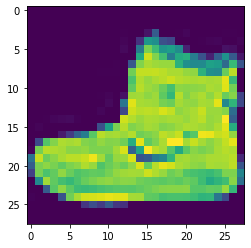

In [11]:
# 查看图形的模样
plt.imshow(mnist[0][0].view(28,28).numpy())

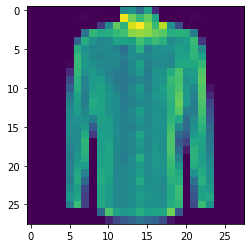

In [12]:
plt.imshow(mnist[3000][0].view(28,28).numpy())

In [13]:
#————————————————————————————进行小批量划分————————————————————————————
batchdata = DataLoader(mnist,batch_size=bs,shuffle=True)

for x,y in batchdata:
    print(x.shape)
    print(y.shape)
    break


torch.Size([128, 1, 28, 28])
torch.Size([128])


In [14]:
mnist.data[0].numel()  # 张量中有多少个元素 28*28

# 对于图像数据总是把后面的维度拉平，相乘起来变成特征输入

784

In [15]:
# 设置参数
input_ = mnist.data[0].numel() 
output_ = len(mnist.targets.unique())  # 10分类

### 3.定义神经网络的架构

In [59]:
#————————————————————————————定义神经网络的架构————————————————————————————

class Model(nn.Module):
    def __init__(self,in_features=10,out_features=2):
        super().__init__()
        self.normalize = nn.BatchNorm2d(num_features=1)
        self.linear1 = nn.Linear(in_features,128,bias=False)
        self.output = nn.Linear(128,out_features,bias=False)  # 2层神经网络

    def forward(self,x):
        x = self.normalize(x)
        x = x.view(-1,28*28)
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = F.log_softmax(self.output(sigma1),dim=1)
        return sigma2



In [17]:
# view(-1,)  # 需要对数据结构进行改变
# -1表示占位符，表示自动计算-1这个位置上的维度应该是多少

### 4.定义训练函数

In [61]:
#————————————————————————————定义损失函数、优化算法————————————————————————————
# 定义一个训练函数

def fit(net,batchdata,lr=0.01,epochs=5,gamma=0):

    criterion = nn.NLLLoss()  # 定义损失函数
    opt = optim.SGD(net.parameters(),lr=lr,momentum=gamma)  # 小批量梯度下降 + 动量
    
    samples = 0 # 虚循环开始前，模型一个样本都没讲过
    correct = 0 # 循环开始前，预测正确的数值为0

    for epcho in range(epochs): # 全数据被训练几次
        for batch_idx,(x, y) in enumerate(batchdata):
            y = y.view(x.shape[0])  # 降维 很多算法要求标签y是一维的
            sigma = net.forward(x)  # 正向传播
            loss = criterion(sigma,y)
            loss.backward()   # 反向传播
            opt.step()   # 更新一步
            opt.zero_grad()  # 梯度清零

            # 求准确率 - 全部判断正确额样本数/已经看过的总样本数
            yhat = torch.max(sigma,1)[1]  # torch.max() 返回结果中每一行的中的最大值
            correct += torch.sum(yhat == y)   # 至今为止所有判断正确的样本
            samples = samples + x.shape[0]  
            #每一次循环都看了128(x.shape[0])个样本
             
            
            # 每125个打印一次 or 整个批次跑到最后一个编号
            if(batch_idx + 1) % 125 == 0 or batch_idx == len(batchdata) -1:   
                print(('Epoch{}:[{}/{}({:.0f}%)]\tLoss:{:.6f}\t Accuracy:{:.3f}'.format   # 分子代表已经查看的数据/分母模型需要查看的数据
                (
                    epcho+1,
                    samples,  # 已经看的数据
                    len(batchdata.dataset)*epochs,   # 总共要看的数据
                    100*samples/(len(batchdata.dataset)*epochs)
                    ,loss.data.item() ,  # 损失函数
                    float(correct*100)/samples   #准确率
                    )
                ))
        


In [54]:
len(batchdata)

469

In [19]:
# enumerate的用法
list = ['A','B','C']
for x in enumerate(list):
    print(x)

(0, 'A')
(1, 'B')
(2, 'C')


In [30]:
# torch.max()的用法
l = torch.tensor([[0.3,0.4,0.25],[0.7,0.2,0.1]])
l

tensor([[0.3000, 0.4000, 0.2500],
        [0.7000, 0.2000, 0.1000]])

In [ ]:
torch.max(l)


In [27]:
torch.max(l,0)

torch.return_types.max(
values=tensor([0.7000, 0.4000, 0.2500]),
indices=tensor([1, 0, 0]))

In [28]:

torch.max(l,1)

torch.return_types.max(
values=tensor([0.4000, 0.7000]),
indices=tensor([1, 0]))

In [31]:
torch.max(l,1)[0]

tensor([0.4000, 0.7000])

In [32]:
l1 = torch.tensor([True,False,False])
torch.sum(l1)

tensor(1)

In [34]:
# 损失函数
loss.data

NameError: name 'loss' is not defined

### 5.进行训练和评估

In [62]:
# 实例化神经网络，调用优化算法需要的参数

torch.manual_seed(420)
net = Model(in_features=input_,out_features=output_)
fit(net,batchdata,lr=lr,epochs=epochs,gamma=gamma)

# 使用batch normalization的结果

Epoch1:[16000/300000(5%)]	Loss:0.469497	 Accuracy:75.075
Epoch1:[32000/300000(11%)]	Loss:0.513013	 Accuracy:79.231
Epoch1:[48000/300000(16%)]	Loss:0.402631	 Accuracy:80.902
Epoch1:[60000/300000(20%)]	Loss:0.399394	 Accuracy:81.685
Epoch2:[76000/300000(25%)]	Loss:0.399464	 Accuracy:82.578
Epoch2:[92000/300000(31%)]	Loss:0.304874	 Accuracy:83.182
Epoch2:[108000/300000(36%)]	Loss:0.353382	 Accuracy:83.634
Epoch2:[120000/300000(40%)]	Loss:0.358590	 Accuracy:83.933
Epoch3:[136000/300000(45%)]	Loss:0.320418	 Accuracy:84.304
Epoch3:[152000/300000(51%)]	Loss:0.341714	 Accuracy:84.678
Epoch3:[168000/300000(56%)]	Loss:0.537747	 Accuracy:84.970
Epoch3:[180000/300000(60%)]	Loss:0.340015	 Accuracy:85.139
Epoch4:[196000/300000(65%)]	Loss:0.335892	 Accuracy:85.391
Epoch4:[212000/300000(71%)]	Loss:0.284877	 Accuracy:85.630
Epoch4:[228000/300000(76%)]	Loss:0.323352	 Accuracy:85.839
Epoch4:[240000/300000(80%)]	Loss:0.337247	 Accuracy:85.961
Epoch5:[256000/300000(85%)]	Loss:0.328442	 Accuracy:86.142
Epoc

我们的模型最后得到的结果属于中规中矩，毕竟我们设置的网格结构只是最普通的全连接层，并且我们并没有对数据进行任何的处理或增强。

在神经网络架构中，有被注释掉的两行关于batch normalization的代码，取消注释，你会看到神经网络的准确率瞬间增加了5%，这是常用的处理之一 。

准确率从83% -->86%